In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bt
import h5py
import time
import vectorbt as vbt
from vectorbt.portfolio import nb
from datetime import datetime
import yfinance as yf
from numba import njit

In [130]:
tickers_new = 'aapl,msft,c,gs,ge,jnj,pg,ko,amzn,jpm,adbe,ma,dis,txn'
data = bt.get(
    tickers_new,
    start='2010-01-01',
    end = '2022-07-01'
)
data

,aapl,msft,c,gs,ge,jnj,pg,ko,amzn,jpm,adbe,ma,dis,txn
Date,,,,,,,,,,,,,,
2010-01-04,6.478998,23.474920,26.893299,136.536942,67.992630,42.974457,40.413692,18.498020,6.695000,29.669846,37.090000,23.853476,27.843178,18.196348
2010-01-05,6.490200,23.482506,27.921572,138.950882,68.344688,42.476143,40.426907,18.274246,6.734500,30.244556,37.700001,23.782906,27.773720,18.091408
2010-01-06,6.386964,23.338388,28.791662,137.467819,67.992630,42.821632,40.235157,18.267763,6.612500,30.410728,37.619999,23.748520,27.626129,17.958487
2010-01-07,6.375156,23.095680,28.870745,140.157837,71.513313,42.516006,40.016960,18.222359,6.500000,31.013121,36.889999,23.593321,27.634809,18.014456
2010-01-08,6.417540,23.254957,28.396164,137.507187,73.053596,42.662178,39.964058,17.885088,6.676000,30.936953,36.689999,23.601692,27.678217,18.427216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-24,140.444214,264.041046,44.782070,289.352966,52.030647,174.613449,138.882568,60.242382,116.459999,111.237907,387.720001,326.949371,97.462357,149.027618
2022-06-27,140.444214,261.269501,44.754005,287.470154,51.805435,174.450592,137.824219,60.118149,113.220001,110.346634,381.070007,325.297272,96.296165,148.712280
2022-06-28,136.260422,252.974411,44.173878,286.237213,51.160873,169.488770,135.582474,59.516106,107.400002,109.815666,365.630005,314.870514,95.608398,147.317108


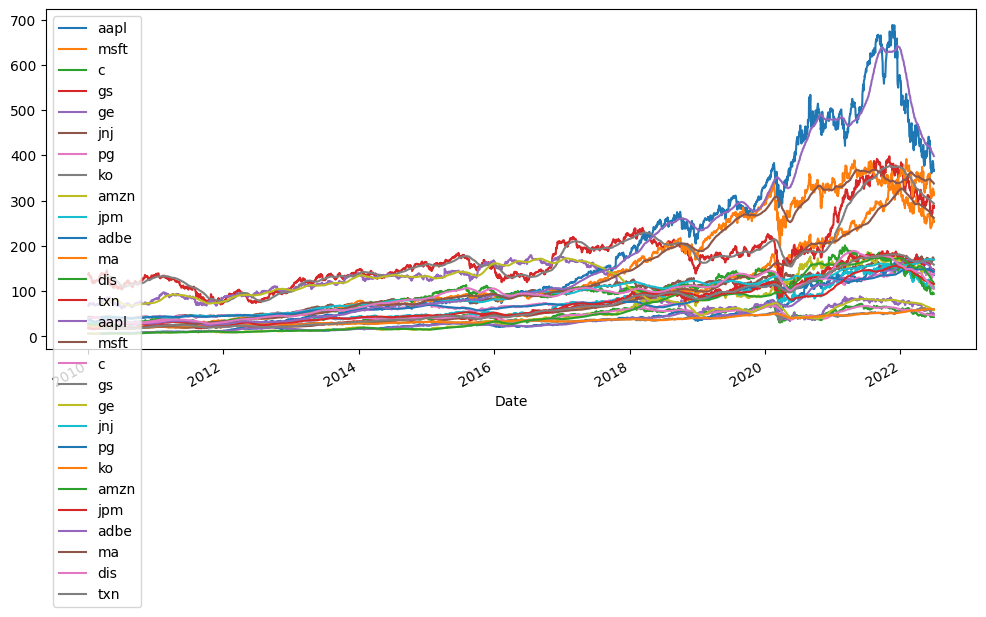

In [131]:
sma = data.rolling(50).mean()

plot = bt.merge(data, sma).plot(figsize=(12, 5))

In [132]:
st = time.time()
class SelectWhere(bt.Algo):

    """
    Selects securities based on an indicator DataFrame.

    Selects securities where the value is True on the current date (target.now).

    Args:
        * signal (DataFrame): DataFrame containing the signal (boolean DataFrame)

    Sets:
        * selected

    """
    def __init__(self, signal):
        self.signal = signal

    def __call__(self, target):
        # get signal on target.now
        if target.now in self.signal.index:
            sig = self.signal.loc[target.now]

            # get indices where true as list
            selected = list(sig.index[sig])

            # save in temp - this will be used by the weighing algo
            target.temp['selected'] = selected

        # return True because we want to keep on moving down the stack
        return True
    
signal = data > sma


# first we create the Strategy
s = bt.Strategy('above50sma', [SelectWhere(data > sma),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])

# now we create the Backtest
t = bt.Backtest(s, data)

# and let's run it!
res = bt.run(t)
et = time.time()

print(f"Run time: {et-st:.2f} seconds") 


Run time: 1.36 seconds


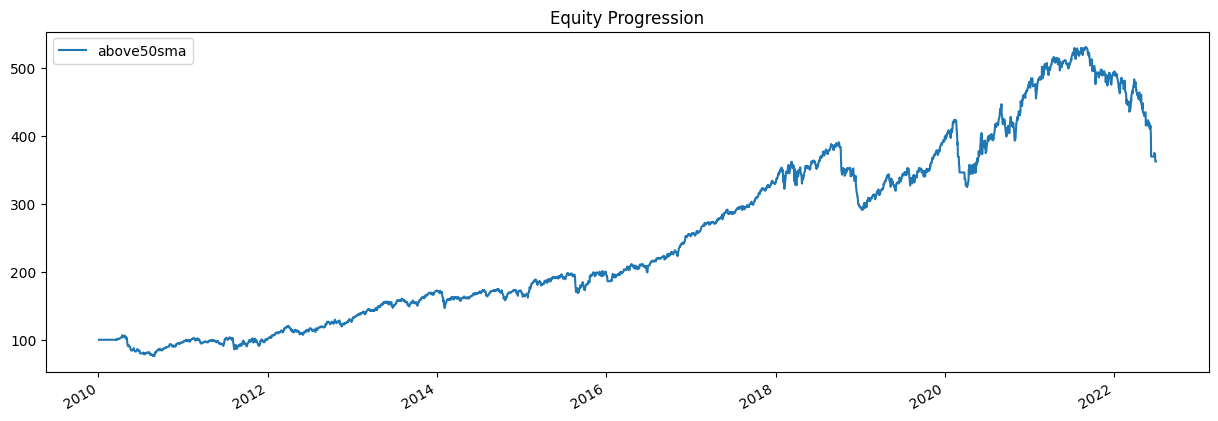

In [133]:
# what does the equity curve look like?
res.plot();

In [152]:
symbols = ["GOOG", "AAPL", "MSFT", "NVDA"]
close = vbt.YFData.download(symbols, missing_index='drop').get('Close')
close

c:\Users\natha\OneDrive\Desktop\C++\Atlas\.venv\lib\site-packages\vectorbt\data\base.py:527: UserWarning:

Symbols have mismatching index. Dropping missing data points.



symbol,GOOG,AAPL,MSFT,NVDA
Date,,,,
2004-08-19 04:00:00+00:00,2.499133,0.464862,16.962107,0.891354
2004-08-20 04:00:00+00:00,2.697639,0.466224,17.012146,0.944101
2004-08-23 04:00:00+00:00,2.724787,0.470462,17.087418,0.964742
2004-08-24 04:00:00+00:00,2.611960,0.483632,17.087418,0.928812
2004-08-25 04:00:00+00:00,2.640104,0.500283,17.281881,0.968563
...,...,...,...,...
2024-01-08 05:00:00+00:00,140.529999,185.559998,374.690002,522.530029
2024-01-09 05:00:00+00:00,142.559998,185.139999,375.790009,531.400024
2024-01-10 05:00:00+00:00,143.800003,186.190002,382.769989,543.500000


In [160]:
# Select 10 ranges from data, each one year long
split_close, split_idxs = close.vbt.rolling_split(window_len=365, n=10)

@njit
def fill_size_nb(c):
    """This is your custom function to select stocks and fill the size array."""
    # Here we select 2 stocks out of 5 randomly, distribute all cash among them, and set all other to 0
    size = np.full(c.group_len, 0, dtype=np.float_)
    selected_indices = np.random.choice(c.group_len, 2, replace=False)
    size[selected_indices] = 1/2
    return size

@njit
def pre_segment_func_nb(c, price):
    """Perform rebalancing at a timestamp."""
    for col in range(c.from_col, c.to_col):
        # Target percentage requires knowing the value of all assets in the group
        # Let's calculate this value using the current order price (remove this to use previous close)
        c.last_val_price[col] = nb.get_col_elem_nb(c, col, price)
        
    # Fill the size array
    size = fill_size_nb(c)
    
    # Sort by order value to first sell the current positions to release funds
    order_value_out = np.empty(c.group_len, dtype=np.float_)
    nb.sort_call_seq_nb(c, size, nb.SizeType.TargetPercent, nb.Direction.LongOnly, order_value_out)
    
    # Forward size to order_func_nb
    return (size,)

@njit
def order_func_nb(c, size, price, fees):
    """Create an order. Gets only executed if the current segment is active."""
    return nb.order_nb(
        size=nb.get_elem_nb(c, size),
        price=nb.get_elem_nb(c, price),
        size_type=nb.SizeType.TargetPercent,
        direction=nb.Direction.LongOnly,
        fees=nb.get_elem_nb(c, fees)
    )

# Use the current close as order price
price = split_close

# Define and run the simulation
pf = vbt.Portfolio.from_order_func(
    split_close,
    order_func_nb,
    vbt.Rep('price'),  # *args passed to order_func_nb
    vbt.Rep('fees'),  # *args passed to order_func_nb
    pre_segment_func_nb=pre_segment_func_nb,
    pre_segment_args=(
        vbt.Rep('price'),
    ),
    broadcast_named_args=dict(  # broadcast to a single shape
        price=price,
        fees=0.001
    ),
    segment_mask=segment_mask,
    cash_sharing=True, # share cash within each split
    group_by='split_idx'  # column level in split_close to split by
)

# Get total return of each split
pf.total_return()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Internal error at <numba.core.typeinfer.CallConstraint object at 0x0000029960AB9820>.
[1m[1m[1mmissing a required argument: 'fees'[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function order_func_nb at 0x000002995DB90B80>))[0m
[0m[1mDuring: typing of call at c:\Users\natha\OneDrive\Desktop\C++\Atlas\.venv\lib\site-packages\vectorbt\portfolio\nb.py (3019)
[0m
Enable logging at debug level for details.
[1m
File "..\..\.venv\lib\site-packages\vectorbt\portfolio\nb.py", line 3019:[0m
[1m        ... def post_sim_func_nb(c):
            <source elided>
                    )
[1m                    order = order_func_nb(order_ctx, *pre_segment_out, *order_args)
[0m                    [1m^[0m[0m


In [140]:
#Define the weights
st = time.time()
weights = [np.zeros(len(data.columns))]

num_tests = 1
_price = data.vbt.tile(num_tests, keys=pd.Index(np.arange(num_tests), name='symbol_group'))
_price = _price.vbt.stack_index(pd.Index(np.concatenate(weights), name='weights'))
_price

# Define allocation weights at the first timestamp and rest of the arrays as null for Buy and Hold Portfolio Backtesting
signals = (_price.rolling(50).mean() > _price)
signals = signals.div(signals.sum(axis=1), axis=0)
signals.replace(np.nan, 0, inplace=True)
size = signals.values

# Set initial capital
initial_capital = 100

portfolio = vbt.Portfolio.from_orders(
    close=_price,
    size=size,
    size_type='targetpercent',
    group_by='symbol_group',
    cash_sharing=True,
    init_cash=initial_capital,
    freq='1D',
    raise_reject=True
)

stats = portfolio.stats()
et = time.time()
print(f"Run time: {(et-st)*1000:.4f} ms")
stats

RejectedOrderError: Not enough cash to long

In [144]:
size.sum(axis=1)

array([0., 0., 0., ..., 1., 1., 1.])

Text(0, 0.5, 'Portfolio Value')

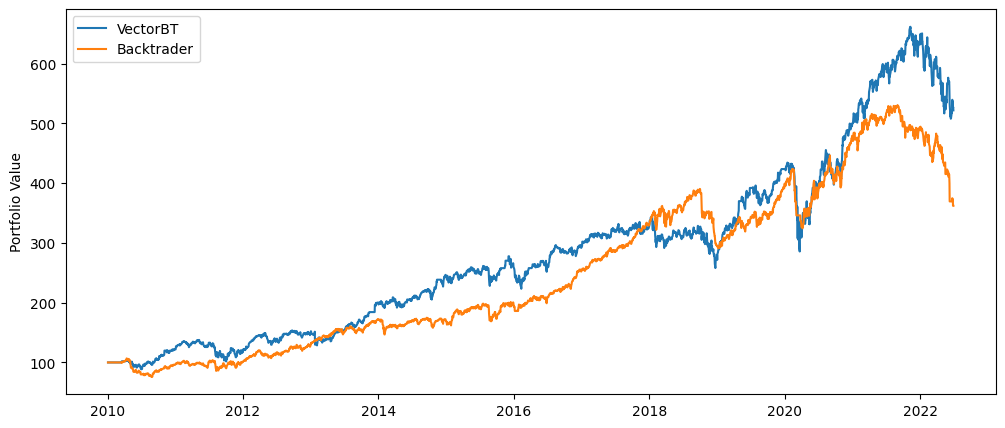

In [136]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

ax.plot(portfolio.value(), label = "VectorBT")
ax.plot(res['above50sma'].prices, label = "Backtrader")

ax.legend(loc='best')
ax.set_ylabel('Portfolio Value')

In [17]:
# convert index to epoch time
data_atlas = data.copy()
data_atlas.index = data_atlas.index.astype('int64')

# split columns into indivual dataframes
dfs = {col: pd.DataFrame(data_atlas[col]) for col in data_atlas}

output_path = os.path.join(os.getcwd(), 'data_sp500.h5')
if os.path.exists(output_path):
    os.remove(output_path)


with h5py.File(output_path, "a") as file:
    for ticker, df in dfs.items():
        #rename ticker column to "close"
        df.columns = ["close"]
        df["50_ma"] = sma[ticker].values
        df.dropna(inplace = True)
        stock_data = df.to_numpy()
        index = df.index.map(lambda timestamp: int(timestamp)).to_numpy()
        print(ticker, len(index))

        dataset = file.create_dataset(f"{ticker}/data", data=stock_data)
        file.create_dataset(
                f"{ticker}/datetime",
                data = index,
        )
        for column in df.columns:
            dataset.attrs[column] = column

aapl 3096
msft 3096
c 3096
gs 3096
ge 3096
jnj 3096
pg 3096
ko 3096
amzn 3096
jpm 3096
adbe 3096
ma 3096
dis 3096
txn 3096


In [79]:
# create a function that returns a random walk of prices
import numpy as np

# set numpy random seed
np.random.seed(0)

def generate_arithmetic_random_walk(n, mean_step, std_dev, s0):
    """
    Generate an arithmetic random walk.

    Parameters:
    - n: Number of steps in the random walk.
    - mean_step: Mean of the step size.
    - std_dev: Standard deviation of the step size.

    Returns:
    - A NumPy array representing the arithmetic random walk.
    """
    # Generate random steps
    steps = np.random.normal(loc=mean_step, scale=std_dev, size=n)

    # Calculate cumulative sum to get the random walk
    random_walk = np.cumsum(steps)

    random_walk += s0

    return random_walk

# Example usage
num_stocks = 500
num_steps = 5000
mean_step_size = 0.01
s0 = 100.0
std_deviation = 0.5

data_large = pd.DataFrame(
    {
        f"stock_{i}": generate_arithmetic_random_walk(
            num_steps, mean_step_size, std_deviation, s0
        )
        for i in range(num_stocks)
    }
)

# set the datetime index to be a range of dates starting from 1/1/2010
data_large.index = pd.date_range("1/1/2010", periods=num_steps, freq="D")


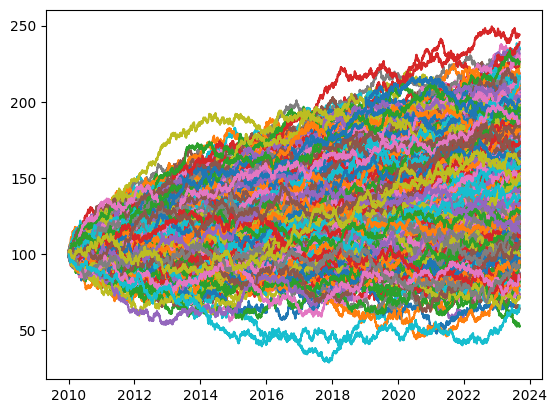

In [80]:
data_large.index = pd.date_range("1/1/2010", periods=num_steps, freq="D")
_ = plt.plot(data_large)

In [81]:
st = time.time()
sma = data_large.rolling(50).mean()
signal = data_large > sma

# first we create the Strategy
s = bt.Strategy('above50sma', [SelectWhere(data_large > sma),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])

# now we create the Backtest
t = bt.Backtest(s, data_large)

# and let's run it!
res = bt.run(t)
et = time.time()

print(f"Run time: {et-st:.2f} seconds") 

Run time: 41.71 seconds


In [85]:
(41.71 * 1000) / 39

1069.4871794871794

In [84]:
data_large.index = data_large.index.astype('int64')

output_path = os.path.join(os.getcwd(), 'data_large.h5')
STORE = True
if STORE:
    if os.path.exists(output_path):
        os.remove(output_path)
    with h5py.File(output_path, "a") as file:
        for col in data_large.columns:
            #rename ticker column to "close"
            df = pd.DataFrame(data_large[col])
            df.columns = ["close"]
            df["50_ma"] = df["close"].rolling(50).mean()
            df.dropna(inplace = True)
            stock_data = df.to_numpy()
            index = df.index.map(lambda timestamp: int(timestamp)).to_numpy()
            print(ticker, len(index))

            dataset = file.create_dataset(f"{col}/data", data=stock_data)
            file.create_dataset(
                    f"{col}/datetime",
                    data = index,
            )
            for column in df.columns:
                dataset.attrs[column] = column

aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951


In [93]:
(1.41 * 1e6) / 493

2860.0405679513183